# Part 1 Preprocess
* * *

In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# extra imports
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from statsmodels.genmod.generalized_linear_model import GLM
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox

### Loading the datasets

Create a list of all files and add the corresponding city names and day type

In [3]:
data = [("/Users/lauraforerocamacho/Downloads/data/amsterdam_weekdays.csv", "Amsterdam", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/athens_weekdays.csv", "Athens","Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/barcelona_weekdays.csv", "Barcelona", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/berlin_weekdays.csv", "Berlin", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/budapest_weekdays.csv", "Budapest", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/lisbon_weekdays.csv", "Lisbon", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/London_weekdays.csv", "London", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/rome_weekdays.csv", "Rome", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/paris_weekdays.csv", "Paris", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/Vienna_weekdays.csv", "Vienna", "Weekdays"),
                 ("/Users/lauraforerocamacho/Downloads/data/amsterdam_weekends.csv", "Amsterdam", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/athens_weekends.csv", "Athens", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/barcelona_weekends.csv", "Barcelona", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/berlin_weekends.csv", "Berlin", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/budapest_weekends.csv", "Budapest", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/lisbon_weekends.csv", "Lisbon", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/London_weekends.csv", "London", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/rome_weekends.csv", "Rome", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/paris_weekends.csv", "Paris", "Weekends"),
                 ("/Users/lauraforerocamacho/Downloads/data/Vienna_weekends.csv", "Vienna", "Weekends")]


Merg data from all csv into one data frame 

In [4]:
dfs = []
for file_path, city_name, day_type in data:
    df = pd.read_csv(file_path, usecols=lambda col: col != 'Unnamed: 0')
    df = df.assign(city=city_name, type=day_type)
    dfs.append(df)
data = pd.concat(dfs)

The length and number of columns of the formed dataset

### Basic Inspection of the dataset

Get descriptive information about the dataset

In [5]:
numeric_colums= ["realSum", "person_capacity","cleanliness_rating","guest_satisfaction_overall",'bedrooms', 'dist',
       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
       'rest_index_norm', 'lng', 'lat']
categorical_colums= ["room_type","room_shared", "room_private", "host_is_superhost","multi", "biz" , 'city', 'type']

In [6]:
for i in categorical_colums:
    data[i] = data[i].astype('object')
    data[i].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

array([False, True], dtype=object)

array([True, False], dtype=object)

array([False, True], dtype=object)

array([1, 0], dtype=object)

array([0, 1], dtype=object)

array(['Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Budapest', 'Lisbon',
       'London', 'Rome', 'Paris', 'Vienna'], dtype=object)

array(['Weekdays', 'Weekends'], dtype=object)

View distributin of the value

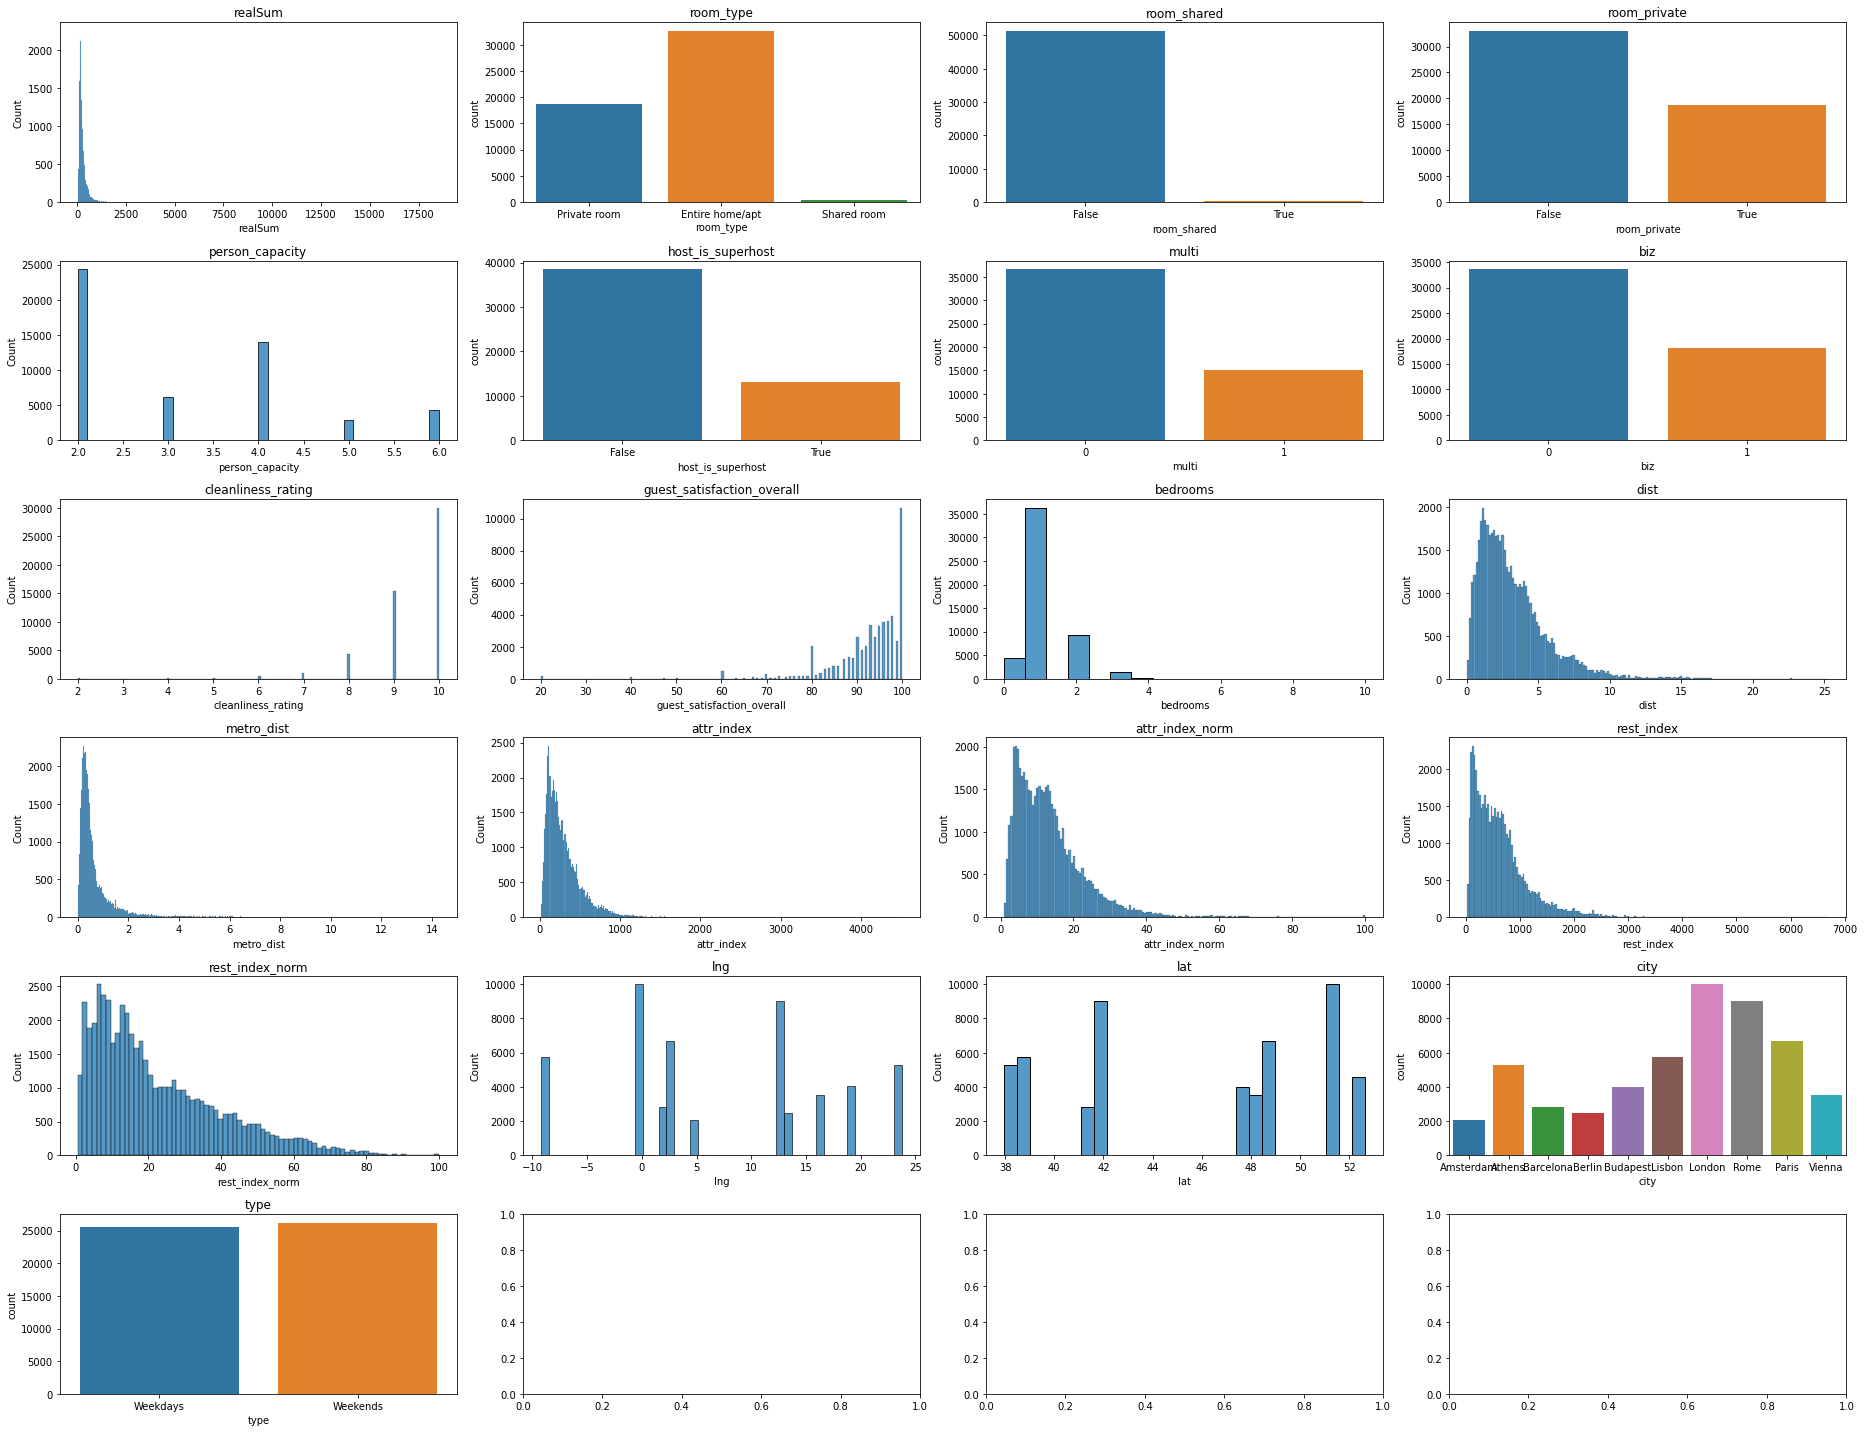

In [7]:
import seaborn as sns


fig, axes = plt.subplots(6,4,figsize=(26,20))

# We will not plot country because it has too many categories.
for i, c in enumerate(data.columns):
    ax = axes.reshape(-1)[i]
    if data[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=data,ax=ax)
    else:
        b = sns.histplot(x=c,data=data,ax=ax)
    t = ax.set_title(c)
plt.tight_layout()

Latitude and longitude are values that can bring noise to the model.

In [8]:
data_clean=data
#data_clean=data_clean.drop(["lat","lng"], axis=1)

In [9]:
def combine_lat_long(lng, lat):
    latitude = np.radians(lat)
    longitude = np.radians(lng)

    amsterdam_latitude = np.radians(0)
    amsterdam_longitude = np.radians(0)

    # apply Haversine formula to compute distance
    latitude_distance = amsterdam_latitude - latitude
    longitude_distance = amsterdam_longitude - longitude
    a = np.sin(latitude_distance/2)**2 + np.cos(latitude) * np.cos(amsterdam_latitude) * np.sin(longitude_distance/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = 6371 * c

    return distance
data_clean['distance'] = combine_lat_long(data_clean['lng'],data_clean['lat'])
data_clean.drop(columns=['lng','lat'],inplace=True)

In [10]:
data_clean

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,city,type,distance
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,Amsterdam,Weekdays,5846.526443
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,Amsterdam,Weekdays,5841.687430
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,Amsterdam,Weekdays,5840.771088
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,Amsterdam,Weekdays,5841.899872
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,Amsterdam,Weekdays,5841.774808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,715.938574,Entire home/apt,False,False,6.0,False,0,1,10.0,100.0,3,0.530181,0.135447,219.402478,15.712158,438.756874,10.604584,Vienna,Weekends,5588.367767
1795,304.793960,Entire home/apt,False,False,2.0,False,0,0,8.0,86.0,1,0.810205,0.100839,204.970121,14.678608,342.182813,8.270427,Vienna,Weekends,5587.534157
1796,637.168969,Entire home/apt,False,False,2.0,False,0,0,10.0,93.0,1,0.994051,0.202539,169.073402,12.107921,282.296424,6.822996,Vienna,Weekends,5587.839197
1797,301.054157,Private room,False,True,2.0,False,0,0,10.0,87.0,1,3.044100,0.287435,109.236574,7.822803,158.563398,3.832416,Vienna,Weekends,5585.322001


### Resampling protocol


In [11]:
X = data_clean.loc[:,data_clean.columns != 'realSum']
y = data_clean['realSum']

In [12]:
from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  StandardScaler

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats


In [13]:
numerical_colums=[
 'person_capacity',
 'cleanliness_rating',
 'guest_satisfaction_overall',
 'bedrooms',
 'dist',
 'attr_index',
 'rest_index',"distance"]

In [14]:
for i in ["room_shared",	"room_private",	"host_is_superhost"]:
    X[i].replace([False, True],[0,1],inplace=True)

/var/folders/zv/hzjbp8kd1l103x8tgl0s00z80000gn/T/ipykernel_3328/2627953380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i].replace([False, True],[0,1],inplace=True)


In [15]:
for column in ["room_type", "city", "type"]:
    X_one_hot = pd.get_dummies(X[column] , dtype=int,drop_first=True)
    X = pd.concat([X, X_one_hot], axis='columns')
 
# drop the values
X= X.drop(["room_type", "city", "type"], axis='columns')

In [16]:
new_columns=['person_capacity', 'host_is_superhost',
       'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall',
       'bedrooms', 'dist', 'attr_index','rest_index', 'Private room', 'Shared room',
       'Athens', 'Barcelona', 'Berlin', 'Budapest', 'Lisbon', 'London',
       'Paris', 'Rome', 'Vienna', 'Weekends',"distance"]
X_new= X[new_columns]

In [17]:
def categorical_preprocessing(X, y,scaler=None):
    print('Original shape:{}'.format(X.shape))
    # Scale numerical variables
    #if scaler is None: 
        # We only want the scaler to fit the train data
    #    scaler =  StandardScaler()
    #    X[numerical_colums] = scaler.fit_transform(X[numerical_colums])
    #else: 
    #    X[numerical_colums] = scaler.transform(X[numerical_colums])
    
    # Apply one hot encoding to categorical variables
    print('New shape:{}'.format(X.shape))
    return X, y, scaler


X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.30, random_state=42,
                                                    stratify=X_new[[ 
        'Private room', 'Shared room', 'Athens', 'Barcelona',
       'Berlin', 'Budapest', 'Lisbon', 'London', 'Paris', 'Rome', 'Vienna',
       'Weekends']])
X_train, y_train, scaler = categorical_preprocessing(X_train,y_train)
X_test, y_test, _ = categorical_preprocessing(X_test,y_test,scaler)

Original shape:(36194, 23)
New shape:(36194, 23)
Original shape:(15513, 23)
New shape:(15513, 23)


In [18]:
from sklearn import linear_model

lr_one_hot = linear_model.LinearRegression()
lr_one_hot.fit(X_train,y_train)

r2_lr_one_hot_train = lr_one_hot.score(X_train,y_train)
r2_lr_one_hot_cv = np.mean(cross_val_score(lr_one_hot, X_train,y_train, cv=10, scoring='r2'))

print('Train R2 score: {}\nCross-Validation R2 score: {}'.format(r2_lr_one_hot_train, r2_lr_one_hot_cv))

LinearRegression()

Train R2 score: 0.3262451048174899
Cross-Validation R2 score: 0.36399454554760285


<Figure size 1440x72 with 0 Axes>

<AxesSubplot:>

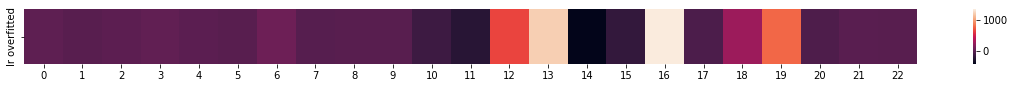

In [19]:
plt.figure(figsize = (20,1))
sns.heatmap(pd.DataFrame({'lr overfitted':lr_one_hot.coef_}).T)

In [20]:
lambdas = [1e-10,1e-5,1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]

RidgeCV(alphas=[1e-10, 1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100],
        cv=5)

/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:620: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 231470623.91778612, tolerance: 237214.90748806307
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:620: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 728043591.9184048, tolerance: 237214.90748806307
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:620: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 811328177.4062856, tolerance: 237214.90748806307
  model = cd_fast.enet_coordinate_descent_gram(
/Users/la

LassoCV(alphas=[1e-10, 1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100],
        cv=5)

/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:620: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184908552.88252926, tolerance: 201666.85198955104
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:620: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 630120927.8402567, tolerance: 201666.85198955104
  model = cd_fast.enet_coordinate_descent_gram(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:620: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 706916645.0265563, tolerance: 201666.85198955104
  model = cd_fast.enet_coordinate_descent_gram(
/Users/la

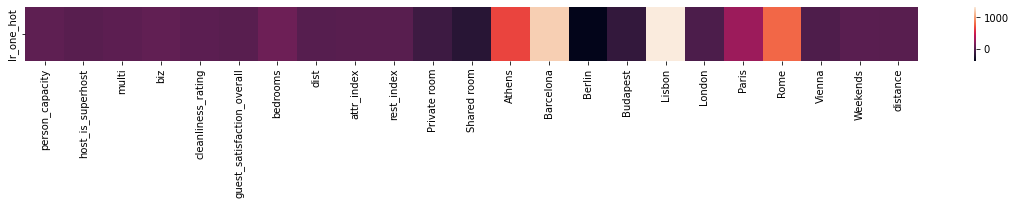

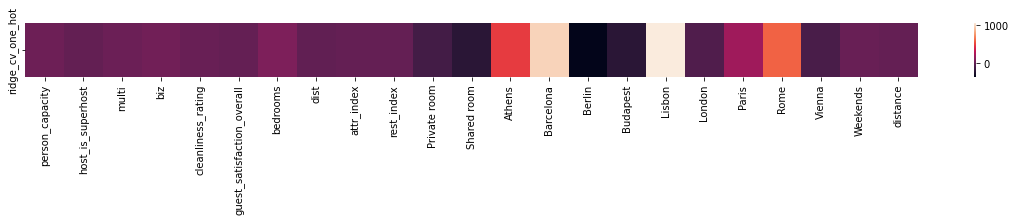

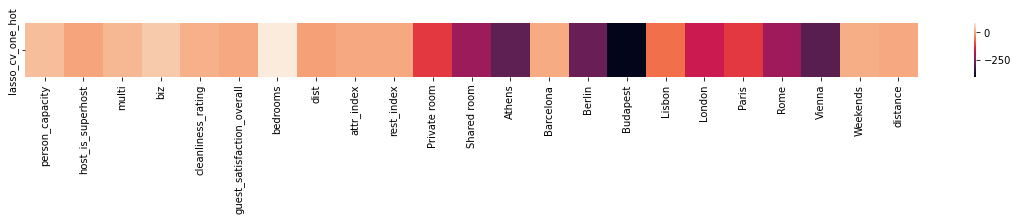

In [21]:
ridge_cv_one_hot = RidgeCV(alphas=lambdas, cv=5)
ridge_cv_one_hot.fit(X_train, y_train)

r2_ridge_one_hot_train = ridge_cv_one_hot.score(X_train,y_train)
r2_ridge_one_hot_cv = np.mean(cross_val_score(ridge_cv_one_hot, X_train, y_train, cv=5, scoring='r2'))

lasso_cv_one_hot = LassoCV(alphas=lambdas, cv=5)
lasso_cv_one_hot.fit(X_train, y_train)

r2_lasso_one_hot_train = ridge_cv_one_hot.score(X_train,y_train)
r2_lasso_one_hot_cv = np.mean(cross_val_score(lasso_cv_one_hot, X_train, y_train, cv=5, scoring='r2'))

weights = pd.DataFrame(
    {
        'lr_one_hot': lr_one_hot.coef_,
        'ridge_cv_one_hot': ridge_cv_one_hot.coef_,
        'lasso_cv_one_hot': lasso_cv_one_hot.coef_
    },
    index=X_train.columns)

for column in weights.columns:
    fig= plt.figure(figsize=(20,1))
    ax=sns.heatmap(weights[[column]].T)

In [22]:
r2_results=pd.DataFrame()
r2_results.loc[:, 'lr_one_hot'] =[r2_lr_one_hot_cv, r2_lr_one_hot_train, 0]
r2_results.loc[:, 'ridge_cv_one_hot'] =[r2_ridge_one_hot_cv, r2_ridge_one_hot_train, ridge_cv_one_hot.alpha_]
r2_results.loc[:, 'lasso_cv_one_hot'] =[r2_lasso_one_hot_cv, r2_lasso_one_hot_train, lasso_cv_one_hot.alpha_]
r2_results

,lr_one_hot,ridge_cv_one_hot,lasso_cv_one_hot
0,0.363995,0.343663,3.436616e-01
1,0.326245,0.326242,3.262424e-01
2,0.000000,0.010000,1.000000e-10
